In [3]:
import torch
import torch.nn
from torchvision.utils import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from torchvision.utils import draw_bounding_boxes
import random
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [4]:
folder = ImageFolder("data/")
images = []


def get_image_annotation(image_path: str, resize_to: tuple):
    annotation_path = str.removesuffix(path, ".jpg") + ".xml"
    root = ET.parse(annotation_path).getroot()

    original_width = int(root.find("size/width").text)
    original_height = int(root.find("size/height").text)

    root = root.find("object")
    original_xmin = int(root.find("bndbox/xmin").text)
    original_xmax = int(root.find("bndbox/xmax").text)
    original_ymin = int(root.find("bndbox/ymin").text)
    original_ymax = int(root.find("bndbox/ymax").text)
    label = root.find("name").text

    xmin = int(original_xmin / (original_width / resize_to[0]))
    xmax = int(original_xmax / (original_width / resize_to[0]))
    ymin = int(original_ymin / (original_height / resize_to[1]))
    ymax = int(original_ymax / (original_height / resize_to[1]))

    return {"bounding_box": torch.tensor([xmin, ymin, xmax, ymax]), "label": label}


train_size = test_size = validation_size = 0
for path, label in folder.imgs:
    if label == 1:
        train_size += 1
    elif label == 0:
        test_size += 1
    else:
        validation_size += 1

RESIZE_TO = (256, 256)

train_data = torch.zeros(size=(train_size, 3, *RESIZE_TO), dtype=torch.uint8)
train_annotations = {
    "bounding_box": torch.zeros(size=(train_size, 4), dtype=torch.uint8),
    "label": [],
}

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Resize(size=RESIZE_TO), lambda x: x * 255]
)
i = 0
for path, label in folder.imgs:
    if label == 1:
        train_data[i] = transform(Image.open(path))
        annotation = get_image_annotation(path, RESIZE_TO)
        train_annotations["bounding_box"][i] = annotation["bounding_box"]
        train_annotations["label"].append(annotation["label"])

        i += 1
train_data.shape

/home/ash/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([516, 3, 256, 256])

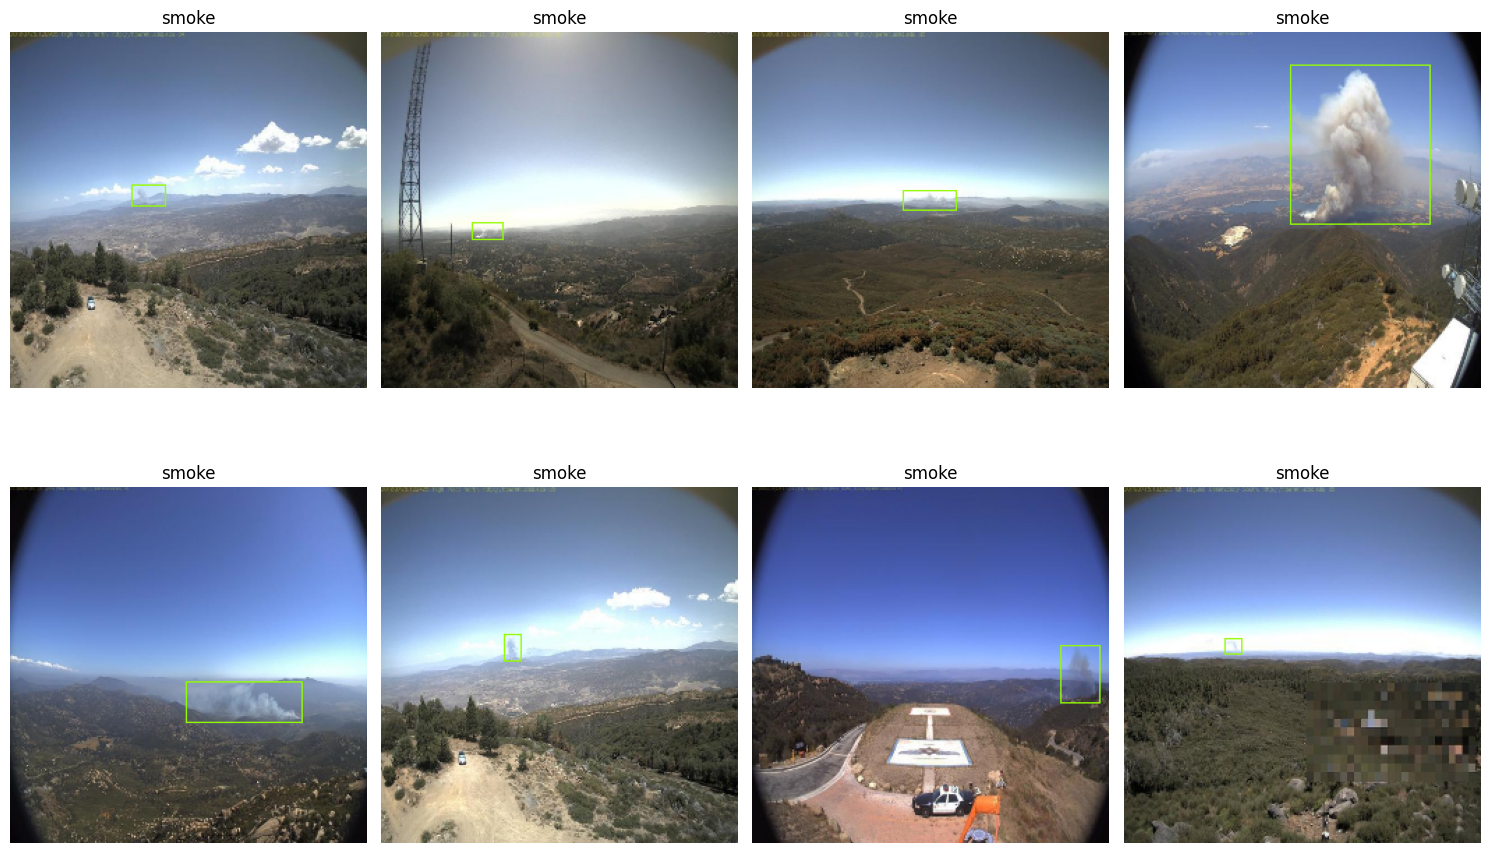

In [8]:
row = 2
col = 4
fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(15, 10), tight_layout=True)
for i in range(row):
    for j in range(col):
        if i == 3 and j == 1:
            break
        random_index = random.randint(0, train_data.__len__() - 1)
        axes[i][j].imshow(
            draw_bounding_boxes(
                train_data[random_index],
                train_annotations["bounding_box"][random_index].reshape(-1, 4),
                colors=(148, 252, 3),
            ).permute(1, 2, 0),
        )
        axes[i][j].set_title(train_annotations["label"][random_index])
        axes[i][j].axis("off")
plt.show()

In [9]:
class FasterRCNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        conv_config = {
            "kernel_size": 3,
            "padding": 1,
            "stride": 1,
        }
        pooling_config = {"kernel_size": 2, "padding": 0, "stride": 2}

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, **conv_config),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=8, out_channels=8, **conv_config),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(**pooling_config),
            nn.Conv2d(in_channels=8, out_channels=16, **conv_config),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, **conv_config),
            nn.ReLU(),
            nn.AvgPool2d(**pooling_config),
            nn.Conv2d(in_channels=16, out_channels=32, **conv_config),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, **conv_config),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, **conv_config),
            nn.ReLU(),
            nn.AvgPool2d(**pooling_config),
            nn.Conv2d(in_channels=32, out_channels=32, **conv_config),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, **conv_config),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, **conv_config),
            nn.ReLU(),
            nn.AvgPool2d(**pooling_config),
            nn.Conv2d(in_channels=64, out_channels=128, **conv_config),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, **conv_config),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, **conv_config),
            nn.ReLU(),
        )

        self.RPN_conv = nn.Conv2d(
            in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1
        )
        self.objectness_head = nn.Conv2d(512, 9, kernel_size=1, stride=1)
        self.bbox_head = nn.Conv2d(512, 9 * 4, kernel_size=1, stride=1)

    def forward(self, x: torch.Tensor):
        out = self.conv_layers(x)
        out = self.RPN_conv(out)

        objectness_scores = self.objectness_head(out)
        bbox_deltas = self.bbox_head(out)

        return objectness_scores, bbox_deltas


model = FasterRCNN()

In [10]:
(model(train_data[0].float()))[1].shape

torch.Size([36, 16, 16])